Our prediction target for the regression is the mass attribute, as we stated it in our previous report. The mass will be predicted based on the following attributes: distance, stellar_magnitude, orbital_radius, orbital_period, eccentricity and radius attributes.

Our goal is to create a model that not only performs well on the training set, but also on the test set.

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [212]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

In [213]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [214]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [215]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

df_std = (df_without_type - np.mean(df_without_type, axis=0)) / np.std(df_without_type, axis=0)
print(np.std(df_std, axis=0))

#we add back everything
df_std["planet_type"] = encoded_df["planet_type"]
df_std["detection_method"] = encoded_df["detection_method"]
df_std["discovery_year"] = encoded_df["discovery_year"]
df_std

distance             1.0
stellar_magnitude    1.0
orbital_radius       1.0
orbital_period       1.0
eccentricity         1.0
mass                 1.0
radius               1.0
dtype: float64


,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method,discovery_year
0,-0.941502,-2.507892,-0.029399,-0.020411,1.082079,1.344301,1.380098,0,5,11
1,-0.876496,-2.416469,-0.027530,-0.020383,0.068518,0.995118,1.402200,0,5,13
2,-0.977410,-2.347623,-0.032981,-0.020433,-0.472049,0.250294,1.534811,0,5,12
3,-1.093801,-1.909940,-0.017851,-0.020190,2.028070,0.500477,1.468505,0,5,6
4,-1.086991,-2.037443,-0.026518,-0.020337,4.122764,0.023999,1.645320,0,5,1
...,...,...,...,...,...,...,...,...,...,...
4260,3.729620,1.067600,-0.038611,-0.020460,-0.472049,-0.107447,-0.456561,1,6,20
4261,0.849559,0.629293,-0.038655,-0.020460,-0.472049,-0.107518,-0.467612,1,6,20
4262,0.691688,0.914350,-0.038553,-0.020460,-0.472049,-0.107711,-0.502975,1,6,20
4263,1.099676,0.866420,-0.038458,-0.020460,-0.472049,-0.107518,-0.467612,1,6,20


In [216]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [217]:
df_regression = df_std.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)
df_regression

,distance,stellar_magnitude,orbital_radius,orbital_period,eccentricity,mass,radius
0,-0.941502,-2.507892,-0.029399,-0.020411,1.082079,1.344301,1.380098
1,-0.876496,-2.416469,-0.027530,-0.020383,0.068518,0.995118,1.402200
2,-0.977410,-2.347623,-0.032981,-0.020433,-0.472049,0.250294,1.534811
3,-1.093801,-1.909940,-0.017851,-0.020190,2.028070,0.500477,1.468505
4,-1.086991,-2.037443,-0.026518,-0.020337,4.122764,0.023999,1.645320
...,...,...,...,...,...,...,...
4260,3.729620,1.067600,-0.038611,-0.020460,-0.472049,-0.107447,-0.456561
4261,0.849559,0.629293,-0.038655,-0.020460,-0.472049,-0.107518,-0.467612
4262,0.691688,0.914350,-0.038553,-0.020460,-0.472049,-0.107711,-0.502975
4263,1.099676,0.866420,-0.038458,-0.020460,-0.472049,-0.107518,-0.467612


In [218]:
# Define features, and target variable
X = df_without_type.drop(columns=['mass']).values
y = df_without_type['mass'].values
print(X.shape, y.shape)

(4000, 6) (4000,)


In [219]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [220]:
lambdas = np.logspace(-4, 4, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []
coeff = []

In [221]:
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        mu_X = np.mean(X_train, axis=0)
        sigma_X = np.std(X_train, axis=0)

        X_train = (X_train - mu_X) / sigma_X
        X_test = (X_test - mu_X) / sigma_X

        mu_y = np.mean(y_train)
        sigma_y = np.std(y_train)
        
        y_train = (y_train - mu_y) / sigma_y
        y_test = (y_test - mu_y) / sigma_y
        
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))
    coeff.append(ridge.coef_)


In [222]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]
optimal_coeff = coeff[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")
print(f"Optimal coefficients = {optimal_coeff}")

Optimal lambda = 1291.5497
Minimum Cross-Validation error = 3.5158
Optimal coefficients = [ 0.01549297  0.01484312  0.01913555 -0.01265755 -0.02952822  0.28139597]


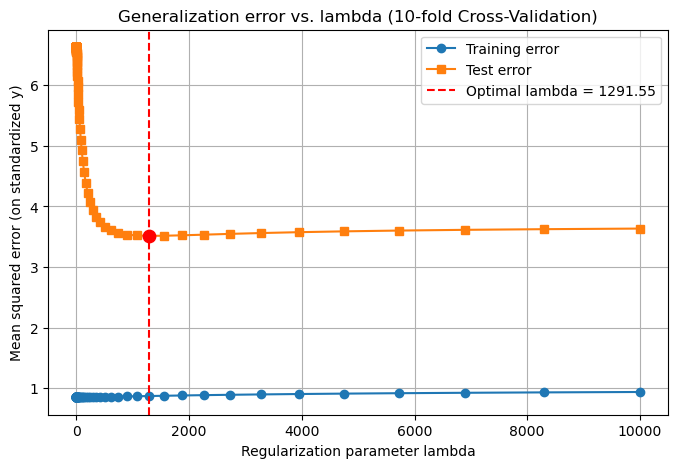

In [223]:

plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Test error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

Ridge Regression Coefficients:
          Feature  Coefficient
           radius     0.281396
     eccentricity    -0.029528
   orbital_radius     0.019136
         distance     0.015493
stellar_magnitude     0.014843
   orbital_period    -0.012658

Intercept: 0.0000
Train Error (MSE): 0.8752
Test Error (MSE): 0.4248


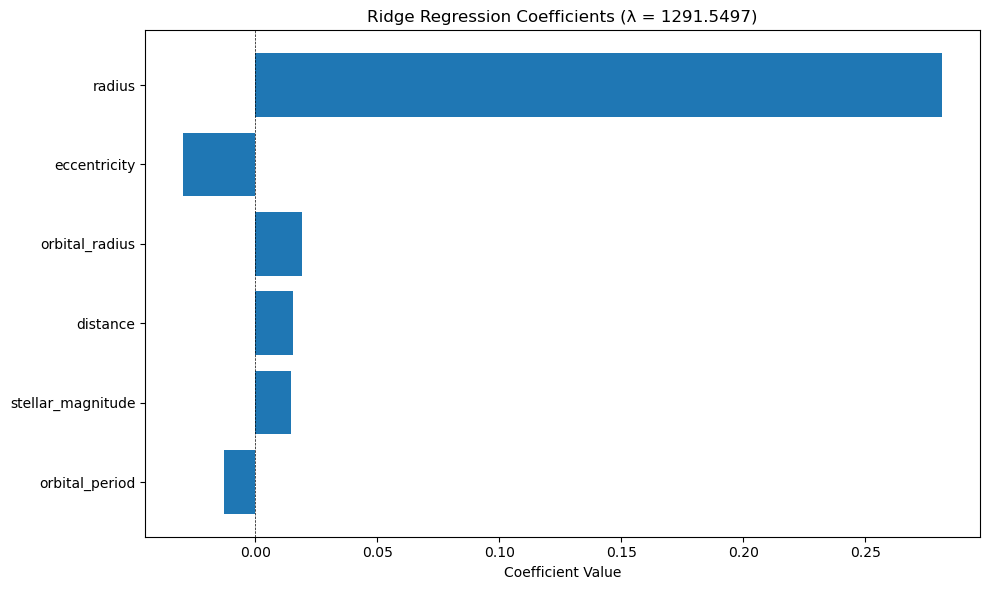

,Feature,Coefficient
5,radius,0.281396
4,eccentricity,-0.029528
2,orbital_radius,0.019136
0,distance,0.015493
1,stellar_magnitude,0.014843
3,orbital_period,-0.012658


In [224]:
ridge = Ridge(alpha=optimal_lambda)

ridge.fit(X_train, y_train)
coeffs = ridge.coef_
intercept = ridge.intercept_

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

train_error = mean_squared_error(y_train, y_pred_train)
test_error = mean_squared_error(y_test, y_pred_test)

# Feature names for regression (excluding 'mass' which is the target)
feature_names = ['distance', 'stellar_magnitude', 'orbital_radius', 'orbital_period', 'eccentricity', 'radius']

# Create DataFrame for coefficients
coeffs_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeffs
}).sort_values('Coefficient', key=abs, ascending=False)

print("Ridge Regression Coefficients:")
print(coeffs_df.to_string(index=False))
print(f"\nIntercept: {intercept:.4f}")
print(f"Train Error (MSE): {train_error:.4f}")
print(f"Test Error (MSE): {test_error:.4f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coeffs_df['Feature'], coeffs_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title(f'Ridge Regression Coefficients (λ = {optimal_lambda:.4f})')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the DataFrame
coeffs_df

As we see the last coefficient is the most signifacnt. This coefficient is the radius. This is in line with our previous analysis from the correlation matrix which also showed the strongest correlation between these 2 attributes.

In [225]:
K1 = 10  # outer folds
K2 = 10  # inner folds

# Regularization and ANN hyperparameters
lambdas = np.linspace(10, 5000, 50)
hidden_units = [1, 8, 16, 32, 64, 128]

In [226]:
# Storage
test_errors_outer = {
    'baseline': np.zeros(K1),
    'ridge': np.zeros(K1),
    'ann': np.zeros(K1)
}
y_true = []
y_preds = {
    'baseline': [],
    'ridge': [],
    'ann': []
}

In [227]:
optimal_hs = np.zeros(K1)
optimal_lambdas = np.zeros(K1)

In [228]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PredictorANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(PredictorANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [229]:
def train_custom_ann(X_train, y_train, X_val, y_val, hidden_units, 
                      lr=1e-3, weight_decay=0.0, epochs=200, batch_size=32, verbose=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert numpy arrays to torch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(device)

    # Datasets and loaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    model = PredictorANN(X_train.shape[1], hidden_units).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    return val_loss, model


In [230]:
# Outer cross-validation loop
from sklearn.neural_network import MLPRegressor


outer_cv = KFold(K1, shuffle=True, random_state=42)

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}/{K1}")

    X_train_outer, y_train_outer = X[outer_train_idx], y[outer_train_idx]
    X_test_outer, y_test_outer = X[outer_test_idx], y[outer_test_idx]

    # Standardize (based on training data)
    X_train_mean = np.mean(X_train_outer, axis=0)
    X_train_std = np.std(X_train_outer, axis=0)

    X_test_mean = np.mean(X_test_outer, axis=0)
    X_test_std = np.std(X_test_outer, axis=0)

    Y_train_mean = np.mean(y_train_outer)
    Y_train_std = np.std(y_train_outer)

    y_test_mean = np.mean(y_test_outer)
    y_test_std = np.std(y_test_outer)

    X_train_outer = (X_train_outer - X_train_mean) / X_train_std
    X_test_outer = (X_test_outer - X_test_mean) / X_test_std
    y_train_outer = (y_train_outer - Y_train_mean) / Y_train_std
    y_test_outer = (y_test_outer - y_test_mean) / y_test_std

    # BASELINE MODEL
    y_pred_baseline = np.full_like(y_test_outer, np.mean(y_train_outer))
    test_errors_outer['baseline'][outer_fold] = np.mean((y_test_outer - y_pred_baseline) ** 2)
    y_preds['baseline'].append(y_pred_baseline)

    #INNER CV for Ridge
    inner_cv = KFold(K2, shuffle=True, random_state=42)
    ridge_val_errors = np.zeros(len(lambdas))

    for i, lam in enumerate(lambdas):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            model = Ridge(alpha=lam)
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            inner_errors.append(mean_squared_error(y_val_inner, y_val_pred))
        ridge_val_errors[i] = np.mean(inner_errors)

    optimal_lambda = lambdas[np.argmin(ridge_val_errors)]
    optimal_lambdas[outer_fold] = optimal_lambda

    # Train Ridge on full outer training set
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_pred = ridge_model.predict(X_test_outer)
    ridge_test_error = np.mean((y_test_outer - ridge_pred) ** 2)
    test_errors_outer['ridge'][outer_fold] = ridge_test_error
    y_preds['ridge'].append(ridge_pred)

    # ----- INNER CV for ANN (PyTorch version) -----
    ann_val_errors = np.zeros(len(hidden_units))

    for j, h in enumerate(hidden_units):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner,
                                            hidden_units=h, lr=1e-3, epochs=10)
            inner_errors.append(val_loss)
        ann_val_errors[j] = np.mean(inner_errors)

    optimal_h = hidden_units[np.argmin(ann_val_errors)]
    optimal_hs[outer_fold] = optimal_h

    # Train final ANN model on full outer training set
    _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer,
                                    hidden_units=optimal_h, lr=1e-3, epochs=10)
    ann_model.eval()

    device = next(ann_model.parameters()).device  # get model’s device
    X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_t = ann_model(X_test_t).cpu().numpy().flatten()

    ann_test_error = mean_squared_error(y_test_outer, y_pred_t)
    test_errors_outer['ann'][outer_fold] = ann_test_error
    y_preds['ann'].append(y_pred_t)

    y_true.append(y_test_outer)


# Results summary
print("\nMean test errors across outer folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")

Outer fold 1/10
Outer fold 2/10
Outer fold 3/10
Outer fold 4/10
Outer fold 5/10
Outer fold 6/10
Outer fold 7/10
Outer fold 8/10
Outer fold 9/10
Outer fold 10/10

Mean test errors across outer folds:
baseline  : 1.0000 ± 0.0000
ridge     : 0.8528 ± 0.0567
ann       : 0.8266 ± 0.0694


In [ ]:
y_true = np.concatenate(y_true)
y_preds_concat = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

In [233]:
# Summarize Results in Table
results_df = pd.DataFrame({
    'Fold': np.arange(1, K1 + 1),
    'lambda* (Ridge)': optimal_lambdas,
    'h* (ANN)': optimal_hs,
    'Baseline Test Error': test_errors_outer['baseline'],
    'Ridge Test Error': test_errors_outer['ridge'],
    'ANN Test Error': test_errors_outer['ann']
})

# Display the table
print("\n===== Table 1: Cross-Validation Results =====")
print(results_df.to_string(index=False))

# Summary statistics
print("\nMean ± Std of Test Errors across folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")


===== Table 1: Cross-Validation Results =====
 Fold  lambda* (Ridge)  h* (ANN)  Baseline Test Error  Ridge Test Error  ANN Test Error
    1      1741.224490      32.0                  1.0          0.888613        0.806177
    2      1639.387755      16.0                  1.0          0.839992        0.798917
    3      2657.755102       8.0                  1.0          0.911095        0.923142
    4      1537.551020      32.0                  1.0          0.893142        0.866392
    5      1639.387755       8.0                  1.0          0.804507        0.819329
    6      1741.224490       8.0                  1.0          0.857711        0.849844
    7       111.836735     128.0                  1.0          0.708764        0.651085
    8      1843.061224      32.0                  1.0          0.848181        0.830594
    9      2046.734694       8.0                  1.0          0.881348        0.895278
   10      2250.408163      32.0                  1.0          0.894275  

In [234]:
import scipy.stats as st
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):

    # 4.1) Calculate estimated error, z_hat, as the mean loss across all samples
    ### BEGIN SOLUTION
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    ### END SOLUTION
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # 4.2) Insert solution from task 3.6 here
    ### BEGIN SOLUTION
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))
    ### END SOLUTION
    
    # 4.3) Insert solution from task 3.7 here
    ### BEGIN SOLUTION
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval
    ### END SOLUTION

    # 4.4) Calculate the p-value for the two-sided test using the t-distribution
    ### BEGIN SOLUTION
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value
    ### END SOLUTION

    return z_hat, CI, p_value

In [235]:
l2_loss = lambda y, y_pred: (y - y_pred)**2
alpha = 0.05

setup1_storage = {
    'ridge_ann': [],
    'ann_baseline': [],
    'ridge_baseline': []
}

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["ann"], l2_loss, alpha=alpha)
setup1_storage['ridge_ann'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and ANN: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ridge_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ann"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ann_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between ANN and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

Difference in loss between Ridge and ANN: 
z_hat: 0.0261, 
CI: [-0.0054, 0.0577], 
p-value: 0.10450523352935599
Difference in loss between Ridge and Baseline: 
z_hat: -0.1472, 
CI: [-0.2203, -0.0742], 
p-value: 7.939690004643683e-05
Difference in loss between ANN and Baseline: 
z_hat: -0.1734, 
CI: [-0.2760, -0.0707], 
p-value: 0.0009380991457885202



Overall misclassification rate: 0.0825


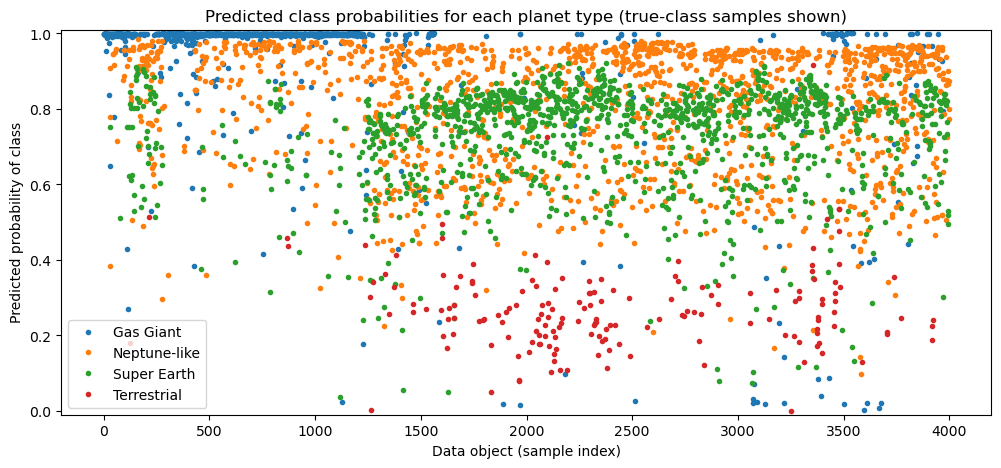

In [236]:
import sklearn.linear_model as lm
X = df_std.drop(columns=['planet_type']).values
y = df_std["planet_type"].values
# Fit the logistic regression model, and define y_est and y_prob
# Fit the logistic regression model
model = lm.LogisticRegression(max_iter=10000)
model = model.fit(X, y)

y_est = model.predict(X)
y_prob = model.predict_proba(X)  # shape (n_samples, n_classes)

# Evaluate classifier's misclassification rate over entire training data
misclass_rate = np.sum(y_est != y) / float(len(y_est))

# Display classification results
print("\nOverall misclassification rate: {0:.4f}".format(misclass_rate))

# Get planet type names in the original categorical order
planet_type_cat = df["planet_type"].astype("category")
class_names = list(planet_type_cat.cat.categories)

# Plot predicted probability for each true class (colored by planet type)
plt.figure(figsize=(12, 5))
cmap = plt.get_cmap('tab10')
colors = [cmap(i % 10) for i in range(len(class_names))]

for i, cls_name in enumerate(class_names):
    cls_ids = np.nonzero(y == i)[0]
    if cls_ids.size == 0:
        continue
    plt.plot(cls_ids, y_prob[cls_ids, i], '.', color=colors[i], label=cls_name)

plt.xlabel("Data object (sample index)")
plt.ylabel("Predicted probability of class")
plt.legend()
plt.ylim(-0.01, 1.01)
plt.title("Predicted class probabilities for each planet type (true-class samples shown)")
plt.show()

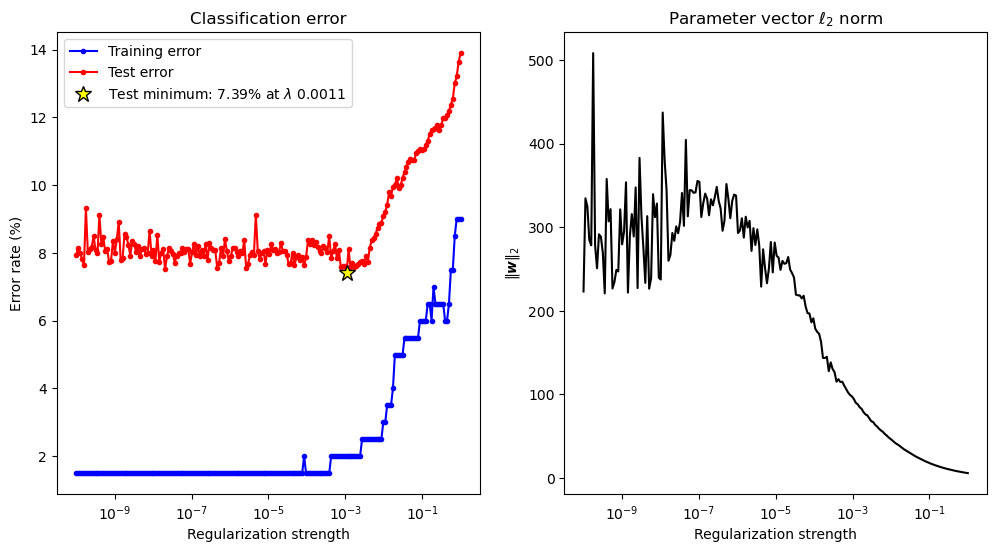

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

# Create crossvalidation partition for evaluation using stratification and 95 pct. split between training and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.95, stratify=y)

# Compute the mean and standard deviation of the training data split, then standardize the training and test sets
# Compute the mean and standard deviation of training data split
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
# Standardize the training and test sets
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Select the range of regularization strengths to test
lambdas = np.logspace(-10, 0, 200)

# Setup storage for quantities computed in the experiment
train_error_rate = np.zeros(len(lambdas))
test_error_rate = np.zeros(len(lambdas))
coefficient_norm = np.zeros(len(lambdas))

# Loop over all values of the regularization strength
for i, regularization_strength in enumerate(lambdas):

    # Create and fit the regularized logistic regression model on the training set using the current regularization strength
    model = LogisticRegression(penalty="l2", C=1/regularization_strength, max_iter=500)
    model.fit(X_train, y_train)

    # Predict on training and test set
    y_train_est = model.predict(X_train).T
    y_test_est = model.predict(X_test).T

    # Compute and store the training and test error rates
    train_error_rate[i] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[i] = np.sum(y_test_est != y_test) / len(y_test)

    # Compute and store the L2 norm of the model coefficients
    ### BEGIN SOLUTION
    coefficient_norm[i] = np.linalg.norm(model.coef_, ord=2)
    ### END SOLUTION

# Find the minimum test error and the corresponding regularization strength
min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambdas[opt_lambda_idx]

# Plot the results
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].semilogx(lambdas, train_error_rate * 100, 'b.-')
axs[0].semilogx(lambdas, test_error_rate * 100, 'r.-')
axs[0].semilogx(opt_lambda, min_error * 100, "*", color='yellow', markersize=12, markeredgecolor='k')
axs[0].set_xlabel("Regularization strength")
axs[0].set_ylabel("Error rate (%)")
axs[0].set_title("Classification error")
# axs[0].set_ylim([-0.1, 4])
axs[0].legend(["Training error", "Test error", fr"Test minimum: {min_error*100:.2f}% at $\lambda$ {opt_lambda:.2g}"], loc="upper left")

axs[1].semilogx(lambdas, coefficient_norm, "k")
axs[1].set_ylabel("$\\|\\boldsymbol{w}\\|_2$")
axs[1].set_xlabel("Regularization strength")
axs[1].set_title(r"Parameter vector $\ell_2$ norm")
plt.show()

In [238]:
class_y_true = []
class_y_preds = {
    'baseline': [],
    'logistic_regression': [],
    'KNN': []
}

In [239]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# features / labels (already defined above but repeated here for clarity)
X = encoded_df.drop(columns=['planet_type']).values
y = encoded_df["planet_type"].values

# 10-fold outer CV to evaluate the majority-class baseline
K_out = 10
outer_cv = StratifiedKFold(n_splits=K_out, shuffle=True, random_state=42)

baseline_misclass = np.zeros(K_out)

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # find most frequent planet type in training set
    # y are encoded integer labels so np.bincount works
    most_freq = np.bincount(y_train).argmax()

    # predict that class for all test samples
    y_pred = np.full_like(y_test, fill_value=most_freq)

    # compute misclassification percentage
    misclass_pct = 100.0 * np.mean(y_pred != y_test)
    baseline_misclass[fold_idx] = misclass_pct

    class_y_true.append(y_test)
    class_y_preds['baseline'].append(y_pred)

    print(f"Fold {fold_idx+1}/{K_out}: majority class = {most_freq}, test misclassification = {misclass_pct:.2f}%")

Fold 1/10: majority class = 1, test misclassification = 63.25%
Fold 2/10: majority class = 1, test misclassification = 63.25%
Fold 3/10: majority class = 1, test misclassification = 63.25%
Fold 4/10: majority class = 1, test misclassification = 63.25%
Fold 5/10: majority class = 1, test misclassification = 63.25%
Fold 6/10: majority class = 1, test misclassification = 63.25%
Fold 7/10: majority class = 1, test misclassification = 63.25%
Fold 8/10: majority class = 1, test misclassification = 63.00%
Fold 9/10: majority class = 1, test misclassification = 63.00%
Fold 10/10: majority class = 1, test misclassification = 63.00%


In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

# features / labels
X = encoded_df.drop(columns=['planet_type', 'discovery_year']).values
y = encoded_df["planet_type"].values

# Nested cross-validation parameters
lambdas = np.logspace(-6, 4, 200)   # inverse-regularization grid for selection (lambda)
K_out = 10
K_in  = 10
outer_cv = StratifiedKFold(n_splits=K_out, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=K_in, shuffle=True, random_state=1)

outer_test_acc = np.zeros(K_out)
outer_test_misclass = np.zeros(K_out)
selected_lambda = np.zeros(K_out)

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # standardize based on outer training fold
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    X_train_std = (X_train - mu) / sigma
    X_test_std = (X_test - mu) / sigma

    # inner CV to pick best lambda
    mean_scores = []
    for lam in lambdas:
        model = LogisticRegression(penalty='l2', C=1/lam, max_iter=1000)
        scores = cross_val_score(model, X_train_std, y_train, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        mean_scores.append(scores.mean())

    best_idx = int(np.argmax(mean_scores))
    optimal_lambda = lambdas[best_idx]
    selected_lambda[fold_idx] = optimal_lambda

    # retrain on full outer training with optimal lambda and evaluate on outer test set
    final_model = LogisticRegression(penalty='l2', C=1/optimal_lambda, max_iter=1000)
    final_model.fit(X_train_std, y_train)
    y_test_pred = final_model.predict(X_test_std)
    outer_test_acc[fold_idx] = accuracy_score(y_test, y_test_pred)
    outer_test_misclass[fold_idx] = 100.0 * np.mean(y_test_pred != y_test)

    class_y_preds['logistic_regression'].append(y_test_pred)

    print(f"Outer fold {fold_idx+1}/{K_out}: optimal lambda={optimal_lambda:.3g}, test acc={outer_test_acc[fold_idx]:.4f}, misclass={outer_test_misclass[fold_idx]:.2f}%")

print(f"\nNested CV test accuracy: mean={outer_test_acc.mean():.4f}, std={outer_test_acc.std():.4f}")
print("Selected lambda per outer fold:",
      np.array2string(selected_lambda,
                      formatter={'float_kind': lambda x: f"{x:.3g}"},
                      separator=", "))

Outer fold 1/10: optimal lambda=1.12e-06, test acc=0.9575, misclass=4.25%
Outer fold 2/10: optimal lambda=1.12e-06, test acc=0.9600, misclass=4.00%
Outer fold 3/10: optimal lambda=4.55e-05, test acc=0.9625, misclass=3.75%
Outer fold 4/10: optimal lambda=3.22e-05, test acc=0.9525, misclass=4.75%
Outer fold 5/10: optimal lambda=0.000129, test acc=0.9550, misclass=4.50%
Outer fold 6/10: optimal lambda=3.57e-06, test acc=0.9475, misclass=5.25%
Outer fold 7/10: optimal lambda=9.01e-06, test acc=0.9600, misclass=4.00%
Outer fold 8/10: optimal lambda=1.78e-06, test acc=0.9400, misclass=6.00%
Outer fold 9/10: optimal lambda=4.5e-06, test acc=0.9425, misclass=5.75%
Outer fold 10/10: optimal lambda=1.61e-05, test acc=0.9500, misclass=5.00%

Nested CV test accuracy: mean=0.9527, std=0.0073
Selected lambda per outer fold: [1.12e-06, 1.12e-06, 4.55e-05, 3.22e-05, 0.000129, 3.57e-06, 9.01e-06,
 1.78e-06, 4.5e-06, 1.61e-05]


In [241]:
print("Selected lambda per outer fold:",
      np.array2string(selected_lambda,
                      formatter={'float_kind': lambda x: f"{x:.3g}"},
                      separator=", "))

Selected lambda per outer fold: [1.12e-06, 1.12e-06, 4.55e-05, 3.22e-05, 0.000129, 3.57e-06, 9.01e-06,
 1.78e-06, 4.5e-06, 1.61e-05]


In [242]:
from sklearn.neighbors import KNeighborsClassifier

# features / labels (already defined above but repeated here for clarity)
X = encoded_df.drop(columns=['planet_type', "discovery_year"]).values
y = encoded_df["planet_type"].values

# Nested (two-level) CV with 10x10 to estimate generalization and select k (KNN) per outer fold
ks = list(range(1,20 , 2))   # odd k values to avoid ties
K_out = 10
K_in  = 10
outer_cv = StratifiedKFold(n_splits=K_out, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=K_in, shuffle=True, random_state=1)

outer_test_acc = np.zeros(K_out)
outer_test_misclass = np.zeros(K_out)
selected_k = np.zeros(K_out, dtype=int)

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # standardize based on outer training fold
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    # avoid division by zero
    sigma[sigma == 0] = 1.0
    X_train_std = (X_train - mu) / sigma
    X_test_std = (X_test - mu) / sigma

    # inner CV to pick best k
    mean_scores = []
    for k in ks:
        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        scores = cross_val_score(model, X_train_std, y_train, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        mean_scores.append(scores.mean())

    best_idx = int(np.argmax(mean_scores))
    best_k = ks[best_idx]
    selected_k[fold_idx] = best_k

    # retrain on full outer training with best_k and evaluate on outer test set
    final_model = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
    final_model.fit(X_train_std, y_train)
    y_test_pred = final_model.predict(X_test_std)
    outer_test_acc[fold_idx] = accuracy_score(y_test, y_test_pred)
    outer_test_misclass[fold_idx] = 100.0 * np.mean(y_test_pred != y_test)

    class_y_preds['KNN'].append(y_test_pred)

    print(f"Outer fold {fold_idx+1}/{K_out}: best k={best_k}, test acc={outer_test_acc[fold_idx]:.4f}, misclass={outer_test_misclass[fold_idx]:.2f}%")

print(f"\nNested CV test accuracy: mean={outer_test_acc.mean():.4f}, std={outer_test_acc.std():.4f}")
print("Selected k per outer fold:", selected_k)

Outer fold 1/10: best k=5, test acc=0.8675, misclass=13.25%
Outer fold 2/10: best k=5, test acc=0.8925, misclass=10.75%
Outer fold 3/10: best k=5, test acc=0.8625, misclass=13.75%
Outer fold 4/10: best k=3, test acc=0.9075, misclass=9.25%
Outer fold 5/10: best k=7, test acc=0.8800, misclass=12.00%
Outer fold 6/10: best k=1, test acc=0.8575, misclass=14.25%
Outer fold 7/10: best k=5, test acc=0.8725, misclass=12.75%
Outer fold 8/10: best k=5, test acc=0.8750, misclass=12.50%
Outer fold 9/10: best k=5, test acc=0.8900, misclass=11.00%
Outer fold 10/10: best k=9, test acc=0.8725, misclass=12.75%

Nested CV test accuracy: mean=0.8778, std=0.0144
Selected k per outer fold: [5 5 5 3 7 1 5 5 5 9]


In [243]:
print(df["planet_type"].value_counts())
print(df["planet_type"].value_counts().idxmax())
print(encoded_df["planet_type"].value_counts())
print(encoded_df["planet_type"].value_counts().idxmax())

planet_type
Neptune-like    1473
Super Earth     1304
Gas Giant       1053
Terrestrial      170
Name: count, dtype: int64
Neptune-like
planet_type
1    1473
2    1304
0    1053
3     170
Name: count, dtype: int64
1


In [244]:
def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    """
    Perform McNemar's test to compare the accuracy of two classifiers.

    Parameters:
    - y_true: array-like, true labels
    - yhatA: array-like, predicted labels by classifier A
    - yhatB: array-like, predicted labels by classifier B
    - alpha: float, significance level (default: 0.05)

    Returns:
    - E_theta: float, estimated difference in accuracy between classifiers A and B (theta_hat)
    - CI: tuple, confidence interval of the estimated difference in accuracy
    - p: float, p-value for the two-sided test of whether classifiers A and B have the same accuracy
    """

    # Set up the contingency table
    nn = np.zeros((2, 2))

    # 2.1) Fill in the contingency table
    ### BEGIN SOLUTION
    # Correctness indicators
    cA = yhatA == y_true
    cB = yhatB == y_true

    # Fill the contingency table
    nn[0, 0] = sum([cA[i] * cB[i] for i in range(len(cA))]) 
    # Or a bit smarter: nn[0, 0] = sum(cA & cB)
    nn[0, 1] = sum(cA & ~cB)
    nn[1, 0] = sum(~cA & cB)
    nn[1, 1] = sum(~cA & ~cB)
    ### END SOLUTION

    # get values from the contingency table
    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]

    # 2.2) Calculate E_theta and Q from the values in the contingency table
    ### BEGIN SOLUTION
    E_theta = (n12 - n21) / n

    Q = (
        n**2
        * (n + 1)
        * (E_theta + 1)
        * (1 - E_theta)
        / ((n * (n12 + n21) - (n12 - n21) ** 2))
    )
    ### END SOLUTION


    # 2.3) Calculate f and g for the beta distribution
    ### BEGIN SOLUTION
    f = (E_theta + 1)/2 * (Q - 1)
    g = (1 - E_theta)/2 * (Q - 1)
    ### END SOLUTION

    # Calculate confidence interval
    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))

    # Calculate p-value for the two-sided test using exact binomial test
    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"Result of McNemars test using alpha = {alpha}\n")
    print("Contingency table")
    print(nn, "\n")
    if n12 + n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=", (n12 + n21))

    print(f"Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = {CI[0]:.4f}, {CI[1]:.4f}\n")
    print(
        f"p-value for two-sided test A and B have same accuracy (exact binomial test): p={p}\n"
    )

    return E_theta, CI, p

In [245]:
class_y_true = np.concatenate(class_y_true)

In [246]:
class_y_preds_concat = {model: np.concatenate(model_preds) for model, model_preds in class_y_preds.items()}

In [247]:
l2_loss = lambda y, y_pred: (y - y_pred)**2
alpha = 0.05

setup1_class_storage = {
    'logistic_regression_KNN': [],
    'KNN_baseline': [],
    'logistic_regression_baseline': []
}

[theta_hat, CI, p] = mcnemar(class_y_true, class_y_preds_concat["logistic_regression"], class_y_preds_concat["KNN"], alpha=alpha)
setup1_class_storage['logistic_regression_KNN'].append((theta_hat, CI, p))
print(f"Difference in loss between Logistic Regression and KNN: \ntheta_hat: {theta_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p}")

[theta_hat, CI, p] = mcnemar(class_y_true, class_y_preds_concat["KNN"], class_y_preds_concat["baseline"], alpha=alpha)
setup1_class_storage['KNN_baseline'].append((theta_hat, CI, p))
print(f"Difference in loss between KNN and Baseline: \ntheta_hat: {theta_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p}")

[theta_hat, CI, p] = mcnemar(class_y_true, class_y_preds_concat["logistic_regression"], class_y_preds_concat["baseline"], alpha=alpha)
setup1_class_storage['logistic_regression_baseline'].append((theta_hat, CI, p))
print(f"Difference in loss between Logistic Regression and Baseline: \ntheta_hat: {theta_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p}")

Result of McNemars test using alpha = 0.05

Contingency table
[[3456.  355.]
 [  55.  134.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.0654, 0.0846

p-value for two-sided test A and B have same accuracy (exact binomial test): p=7.998667380961916e-55

Difference in loss between Logistic Regression and KNN: 
theta_hat: 0.0750, 
CI: [0.0654, 0.0846], 
p-value: 7.998667380961916e-55
Result of McNemars test using alpha = 0.05

Contingency table
[[1327. 2184.]
 [ 146.  343.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.4918, 0.5270

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.0

Difference in loss between KNN and Baseline: 
theta_hat: 0.5095, 
CI: [0.4918, 0.5270], 
p-value: 0.0
Result of McNemars test using alpha = 0.05

Contingency table
[[1413. 2398.]
 [  60.  129.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.5682, 0.6006

p-value for two-sided test A and B have same

In [248]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Use the optimal lambda from nested CV (mean across folds)
optimal_lambda_mean = np.mean(selected_lambda)
print(f"Using optimal lambda (mean from nested CV): {optimal_lambda_mean:.4f}")

# Prepare full dataset
X_full = encoded_df.drop(columns=['planet_type', 'discovery_year']).values
y_full = encoded_df["planet_type"].values

# Standardize features
mu_full = np.mean(X_full, axis=0)
sigma_full = np.std(X_full, axis=0)
X_full_std = (X_full - mu_full) / sigma_full

# Train final logistic regression model on full dataset
final_logistic_model = LogisticRegression(
    penalty='l2',
    C=1/optimal_lambda_mean,
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs'
)
final_logistic_model.fit(X_full_std, y_full)


Using optimal lambda (mean from nested CV): 0.0000


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(41004.36907338567)
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [249]:

# Get feature names
feature_names = encoded_df.drop(columns=['planet_type', 'discovery_year']).columns.tolist()

# Get class names
planet_type_cat = df["planet_type"].astype("category")
class_names = list(planet_type_cat.cat.categories)
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

# Get coefficients for each class
coefficients = final_logistic_model.coef_ 
intercepts = final_logistic_model.intercept_

print(f"\nCoefficient matrix shape: {coefficients.shape}")
print(f"Features: {feature_names}")

# Analyze feature importance across all classes
# Use mean absolute coefficient as overall importance measure
feature_importance = np.mean(np.abs(coefficients), axis=0)


Number of classes: 4
Classes: ['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial']

Coefficient matrix shape: (4, 8)
Features: ['distance', 'stellar_magnitude', 'orbital_radius', 'orbital_period', 'eccentricity', 'detection_method', 'mass', 'radius']


          Feature  Mean |Coefficient|
           radius           41.224385
             mass            6.719238
 detection_method            0.986588
   orbital_radius            0.957773
   orbital_period            0.596396
stellar_magnitude            0.451888
     eccentricity            0.127338
         distance            0.095533


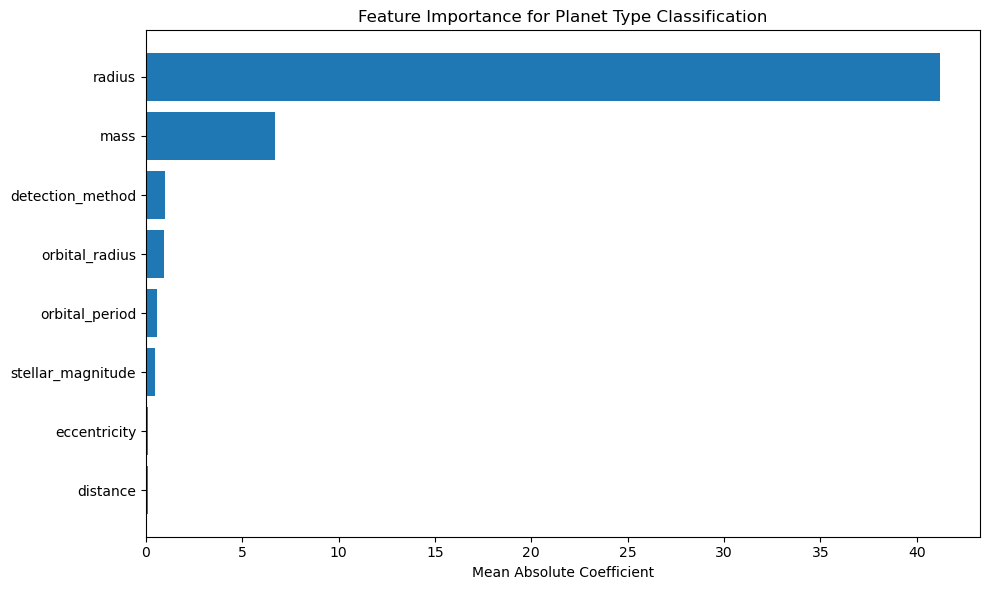

In [250]:
# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |Coefficient|': feature_importance
}).sort_values('Mean |Coefficient|', ascending=False)

print(importance_df.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Mean |Coefficient|'])
plt.xlabel('Mean Absolute Coefficient')
plt.title('Feature Importance for Planet Type Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Class 0: Gas Giant
          Feature  Coefficient
           radius    44.108954
             mass     9.374521
 detection_method    -0.694511
   orbital_period    -0.619043
stellar_magnitude     0.406292
   orbital_radius    -0.356267
     eccentricity     0.241597
         distance    -0.110723

Class 1: Neptune-like
          Feature  Coefficient
           radius    38.339816
             mass   -12.058366
   orbital_radius    -1.559280
 detection_method    -1.278665
   orbital_period    -0.573749
stellar_magnitude     0.497485
         distance    -0.037262
     eccentricity    -0.006143

Class 2: Super Earth
          Feature  Coefficient
           radius    -9.756028
             mass    -1.380109
stellar_magnitude    -0.373039
 detection_method     0.189015
   orbital_radius     0.078205
   orbital_period     0.074144
         distance    -0.043081
     eccentricity     0.013080

Class 3: Terrestrial
          Feature  Coefficient
           radius   -72.692742
             m

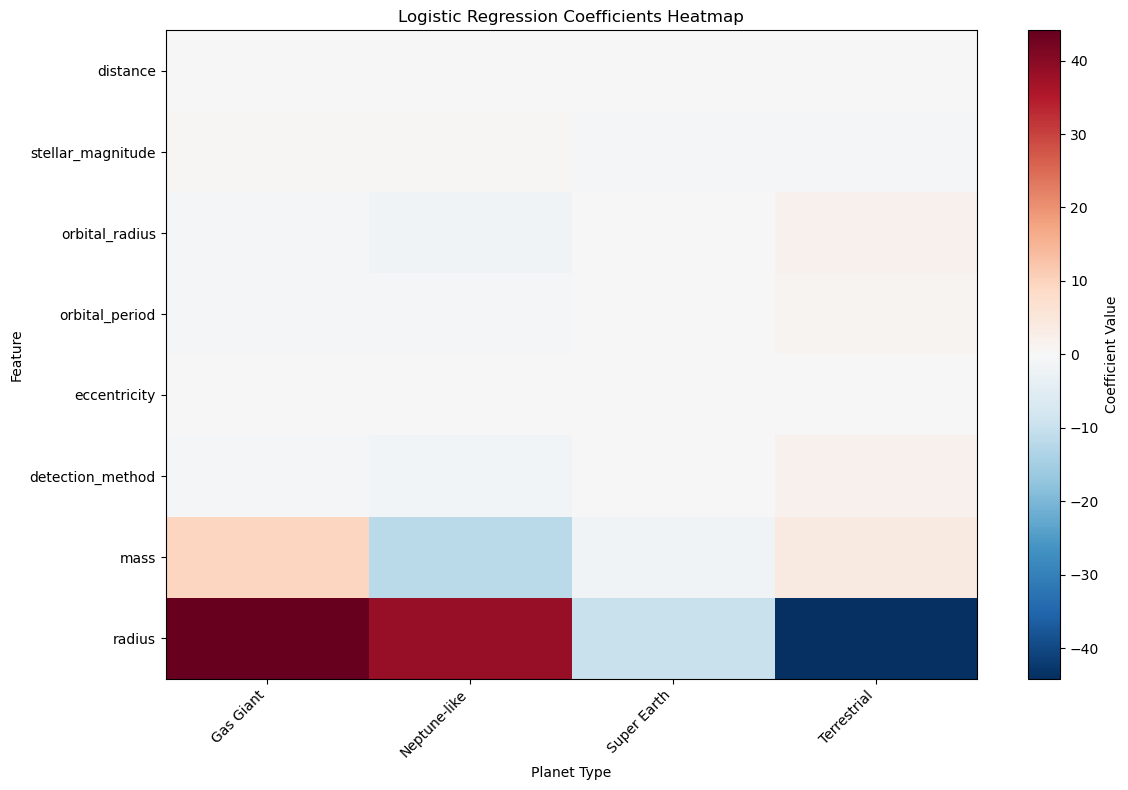

In [251]:
# Show coefficients for each class
for class_idx, class_name in enumerate(class_names):
    print(f"\nClass {class_idx}: {class_name}")
    class_coefs = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients[class_idx, :]
    }).sort_values('Coefficient', key=abs, ascending=False)
    print(class_coefs.to_string(index=False))

# Visualize coefficients heatmap
plt.figure(figsize=(12, 8))
plt.imshow(coefficients.T, aspect='auto', cmap='RdBu_r', vmin=-coefficients.max(), vmax=coefficients.max())
plt.colorbar(label='Coefficient Value')
plt.yticks(range(len(feature_names)), feature_names)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.xlabel('Planet Type')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients Heatmap')
plt.tight_layout()
plt.show()
